<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/RELIANCE_Historical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [2]:
df = pd.read_csv('RELIANCE.csv') ##Source File to be changed here
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,03/1/2000,233.05,4456424,237.50,251.70,237.50
1,04/1/2000,251.70,9487878,258.40,271.85,251.30
2,05/1/2000,271.85,26833684,256.65,287.90,256.65
3,06/1/2000,282.50,15682286,289.00,300.70,289.00
4,07/1/2000,294.35,19870977,295.00,317.90,293.00


### preprocessing data set to perform analysis

In [3]:
df.shape

(5075, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5075 entries, 0 to 5074
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        5075 non-null   object 
 1   Close/Last  5075 non-null   float64
 2   Volume      5075 non-null   int64  
 3   Open        5075 non-null   float64
 4   High        5075 non-null   float64
 5   Low         5075 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 238.0+ KB


In [5]:
df1 = df.iloc[:,1]
df1.head()

0    233.05
1    251.70
2    271.85
3    282.50
4    294.35
Name: Close/Last, dtype: float64

In [6]:
df1.tail()

5070    1441.25
5071    1431.55
5072    1424.05
5073    1445.55
5074    1472.25
Name: Close/Last, dtype: float64

In [7]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    233.05
1    251.70
2    271.85
3    282.50
4    294.35
Name: Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

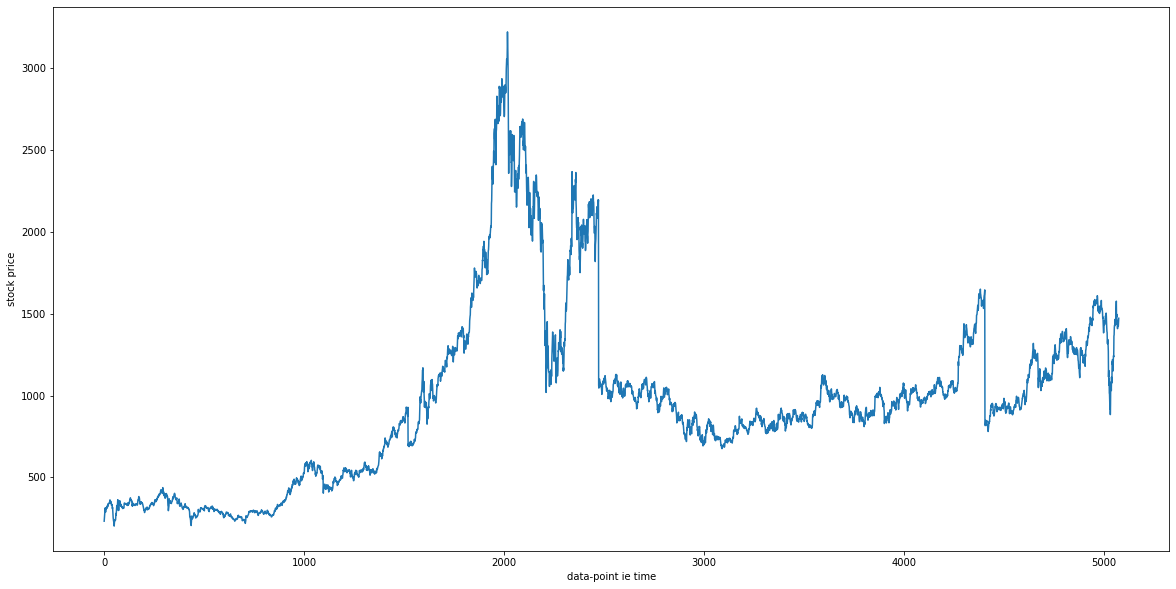

In [8]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

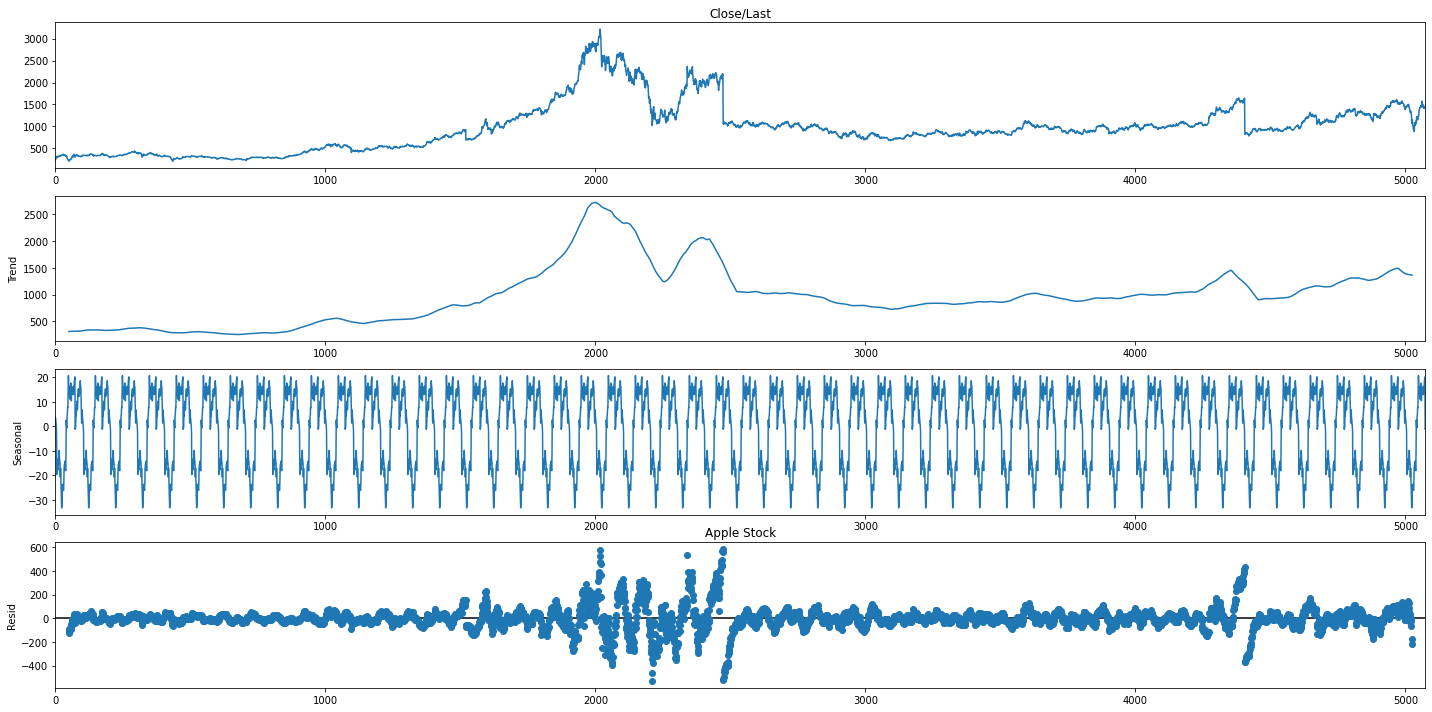

In [9]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [11]:
df1.shape

(5075,)

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.0098918 ]
 [0.01607211]
 [0.02274949]
 ...
 [0.40456978]
 [0.41169453]
 [0.42054248]]

 df1 present shape :  (5075, 1)


### splitting data (70/30)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  3552
Test Size :  1523


In [15]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (3552, 1)
Test Data Shape:  (1523, 1)


### | windowing data set |

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [17]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3451, 100) (3451,)
(1422, 100) (1422,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [23]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
54/54 [==============================] - 17s 196ms/step - loss: 0.0069 - val_loss: 9.0040e-04
Epoch 2/2
54/54 [==============================] - 9s 170ms/step - loss: 9.6651e-04 - val_loss: 0.0012


In [24]:
y_pred = scaler.inverse_transform(model.predict(X_test))

45/45 [==============================] - 3s 31ms/step


In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
y_pred[:5]

array([[1047.8495],
       [1047.0627],
       [1046.7223],
       [1046.7019],
       [1046.8727]], dtype=float32)

In [27]:
y_test[:5]

array([[1013.05],
       [1009.3 ],
       [ 998.35],
       [ 995.1 ],
       [ 998.3 ]])

### evaluation

In [28]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  104.57936021392779


In [29]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.7485102404510833


### visualization + plotting

108/108 [==============================] - 3s 32ms/step


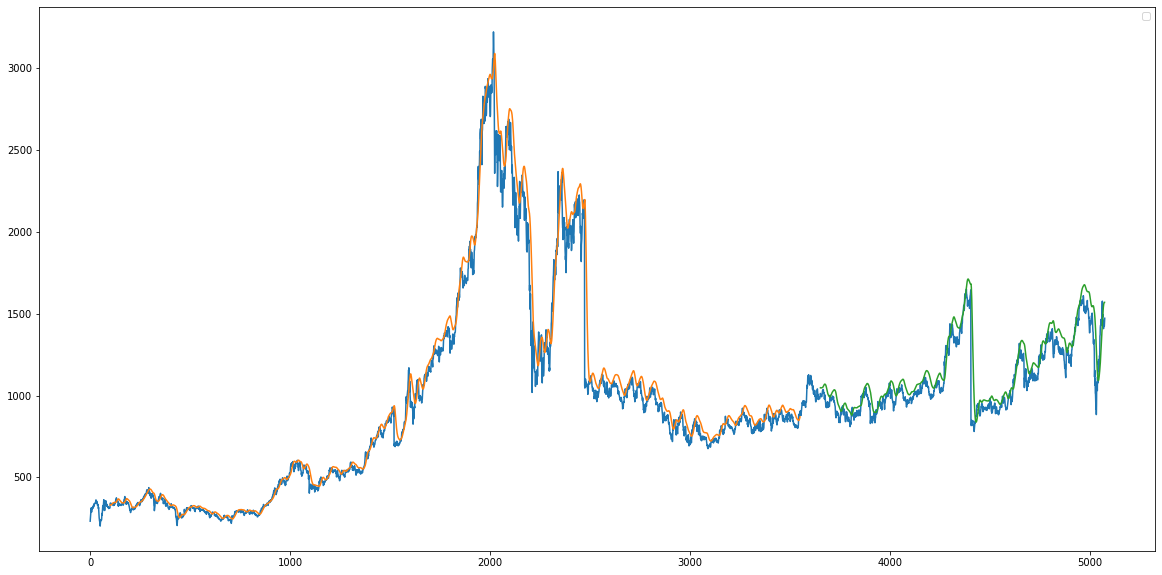

In [30]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [31]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
print(scaler.inverse_transform(lst_output))

[[1566.58808572]
 [1565.80261109]
 [1566.63476094]
 [1569.27051666]
 [1573.63910101]
 [1579.53618625]
 [1586.70663253]
 [1594.89305167]
 [1603.86242731]
 [1613.4187955 ]
 [1623.40729165]
 [1633.7088445 ]
 [1644.23765799]
 [1654.93338708]
 [1665.7565512 ]
 [1676.68160938]
 [1687.69381263]
 [1698.78515689]
 [1709.95312405]
 [1721.19636511]
 [1732.51586934]
 [1743.9123562 ]
 [1755.38780421]
 [1766.94293284]
 [1778.57846155]
 [1790.29492995]
 [1802.09233802]
 [1813.97086564]
 [1825.92961348]
 [1837.96786207]]


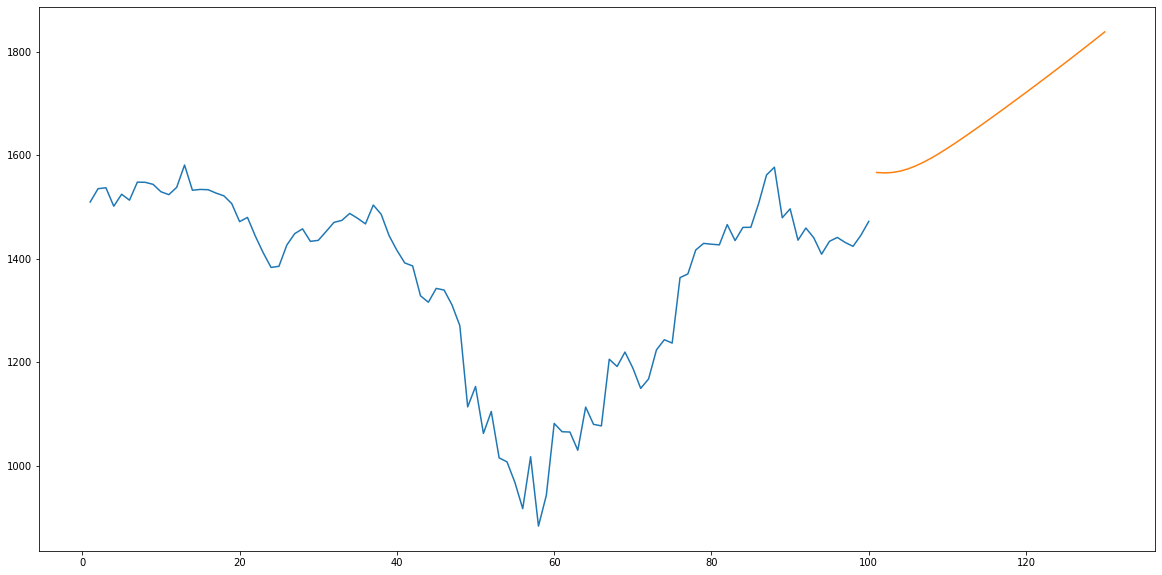

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

Dataset File 

https://www.kaggle.com/datasets/tarunpaparaju/apple-aapl-historical-stock-data